# Análisis de resultados

- Autor: Lucía Cordero Sánchez
- Máster en Inteligencia Artificial Aplicada – UC3M
- Asignatura: Computación Evolutiva

## Introducción
El objetivo es entender cómo los parámetros evolutivos (población, mutación, elitismo, penalización, etc.) afectan al rendimiento del optimizador evolutivo y justificar las decisiones de diseño adoptadas.

## Configuración inicial e importación de datasets

In [ ]:
import os
import json
import time
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from evopt import EvolutionaryOptimizer

warnings.filterwarnings("ignore")

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

DATASETS = {
    "California": "data/california.csv",
    "Diabetes": "data/diabetes.csv"
}

MAXTIME = 180           # Tiempo máximo del optimizador por ejecución (segundos)
TEST_SIZE = 0.25        # Porcentaje de validación
RANDOM_STATE = 42

## Definición de modelos

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor


MODELOS = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "Lasso": Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=2000),
    "ElasticNet": ElasticNet(alpha=0.001, random_state=RANDOM_STATE, max_iter=2000),
    "BayesianRidge": BayesianRidge(),
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=RANDOM_STATE),
    "SVR": SVR(),
    "MLP": MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=RANDOM_STATE),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "Huber": HuberRegressor(max_iter=2000)


}

print(f"🧠 Se evaluarán {len(MODELOS)} modelos en cada escenario.")


🧠 Se evaluarán 14 modelos en cada escenario.


## Definición de los escenarios evolutivos

In [10]:
CONFIGURACIONES = [
    # 🧩 Balance clásico entre exploración y explotación
    {"name": "EquilibrioAdaptativo", "pop_size": 25, "crossover_prob": 0.7, "mutation_prob": 0.35, "elitism": True,
     "complexity_penalty": 0.001, "patience": 30},

    # 🌱 Mayor diversidad con población grande y mutación elevada
    {"name": "DiversidadDirigida", "pop_size": 50, "crossover_prob": 0.75, "mutation_prob": 0.55, "elitism": True,
     "complexity_penalty": 0.001, "patience": 40},

    # 🧬 Evaluar el impacto del elitismo desactivado
    {"name": "SinElitismo", "pop_size": 25, "crossover_prob": 0.7, "mutation_prob": 0.35, "elitism": False,
     "complexity_penalty": 0.001, "patience": 30},

    # ⚡ Mutación muy alta para explorar regiones no lineales del espacio
    {"name": "MutacionAlta", "pop_size": 25, "crossover_prob": 0.65, "mutation_prob": 0.6, "elitism": True,
     "complexity_penalty": 0.001, "patience": 30},

    # ⚖️ Fuerte penalización para evaluar regularización en la complejidad de los individuos
    {"name": "PenalizacionFuerte", "pop_size": 25, "crossover_prob": 0.7, "mutation_prob": 0.35, "elitism": True,
     "complexity_penalty": 0.005, "patience": 30},

    # 🧪 Población muy pequeña: evolución rápida pero riesgo de óptimos locales
    {"name": "PoblacionPequena", "pop_size": 10, "crossover_prob": 0.6, "mutation_prob": 0.35, "elitism": True,
     "complexity_penalty": 0.001, "patience": 30},

    # 🔁 Microevolución prolongada: pequeñas poblaciones con paciencia alta
    {"name": "MicroEvolucion", "pop_size": 12, "crossover_prob": 0.65, "mutation_prob": 0.3, "elitism": True,
     "complexity_penalty": 0.001, "patience": 60},

    # 🧠 Escenario experimental: cruce alto + mutación media → recombinación intensa
    {"name": "CruceAltoMutacionMedia", "pop_size": 30, "crossover_prob": 0.85, "mutation_prob": 0.4, "elitism": True,
     "complexity_penalty": 0.001, "patience": 35},

    # 🚀 Exploración extrema: cruce bajo, mutación alta y sin elitismo
    {"name": "ExploracionExtrema", "pop_size": 40, "crossover_prob": 0.5, "mutation_prob": 0.65, "elitism": False,
     "complexity_penalty": 0.001, "patience": 40}
]

print(f"🧪 Se evaluarán {len(CONFIGURACIONES)} escenarios evolutivos en total.")



🧪 Se evaluarán 9 escenarios evolutivos en total.


## Funciones auxiliares

In [11]:
def evaluar_modelo(modelo, X_train, X_val, y_train, y_val):
    m = clone(modelo)
    m.fit(X_train, y_train)
    y_pred = m.predict(X_val)
    return mean_squared_error(y_val, y_pred)


def evaluar_configuracion(cfg_name, evo_params, dataset_name, path_csv):
    print("\n" + "="*90)
    print(f"🧩 Escenario: {cfg_name} | Dataset: {dataset_name}")
    print("="*90)
    print(f"🔧 Parámetros evolutivos → {evo_params}")

    df = pd.read_csv(path_csv)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    print("\n🚀 Iniciando optimización evolutiva...")
    opt = EvolutionaryOptimizer(maxtime=MAXTIME, **{k: v for k, v in evo_params.items() if k != 'name'})
    start = time.time()
    opt.fit(X_train, y_train)
    elapsed = time.time() - start
    print(f"✅ Finalizado en {elapsed:.1f} segundos | Fitness óptimo: {opt.best_fit:.4f}")

    X_train_opt = opt.transform(X_train)
    X_val_opt = opt.transform(X_val)
    print(f"✨ Conjunto de entrenamiento ampliado a {X_train_opt.shape[1]} variables tras la evolución.")
    print("-"*70)

    resultados = []
    for i, (nombre, modelo) in enumerate(MODELOS.items(), 1):
        try:
            print(f"[{i:02d}/{len(MODELOS)}] 🧠 Evaluando {nombre}...")
            mse_base = evaluar_modelo(modelo, X_train, X_val, y_train, y_val)
            mse_opt = evaluar_modelo(modelo, X_train_opt, X_val_opt, y_train, y_val)
            mejora = 100 * (1 - mse_opt / mse_base)
            tendencia = "⬆️ mejora" if mejora > 0 else "⬇️ empeora"
            print(f"   • MSE base: {mse_base:.4f} | MSE tras evolución: {mse_opt:.4f} | Δ {mejora:+.2f}% {tendencia}")

            resultados.append({
                "config": cfg_name,
                "dataset": dataset_name,
                "modelo": nombre,
                "mse_original": mse_base,
                "mse_optimizado": mse_opt,
                "mejora_%": mejora,
                "tiempo_optimizador_s": elapsed,
                "num_features": X_train_opt.shape[1],
                **evo_params
            })
        except Exception as e:
            print(f"   ⚠️ Error con {nombre}: {e}")
            continue

    mean_improvement = np.mean([r["mejora_%"] for r in resultados]) if resultados else 0
    print("-"*70)
    print(f"🧾 Resumen del escenario {cfg_name}:")
    print(f"   ▫️ Modelos evaluados: {len(resultados)}")
    print(f"   ▫️ Mejora media: {mean_improvement:.2f}%")
    print(f"   ▫️ Tiempo optimizador: {elapsed:.1f}s")
    print(f"   ▫️ Features generadas: {X_train_opt.shape[1]}")
    print("-"*70)

    return resultados


## Ejecución global de experimentos

In [12]:
all_results = []
for cfg in CONFIGURACIONES:
    for dataset_name, path in DATASETS.items():
        res = evaluar_configuracion(cfg["name"], cfg, dataset_name, path)
        all_results.extend(res)


df = pd.DataFrame(all_results)
df.to_csv(os.path.join(RESULTS_DIR, "all_results.csv"), index=False)
print("✅ Resultados globales guardados en results/all_results.csv")
print(f"Total de ejecuciones registradas: {len(df)}")
print(df.groupby(['dataset','config'])['mejora_%'].mean().round(2))


🧩 Escenario: EquilibrioAdaptativo | Dataset: California
🔧 Parámetros evolutivos → {'name': 'EquilibrioAdaptativo', 'pop_size': 25, 'crossover_prob': 0.7, 'mutation_prob': 0.35, 'elitism': True, 'complexity_penalty': 0.001, 'patience': 30}

🚀 Iniciando optimización evolutiva...
[STOP] Early stopping at gen 34
[DONE] Best fitness: -0.41138 | Time: 17.0s
✅ Finalizado en 17.0 segundos | Fitness óptimo: -0.4114
✨ Conjunto de entrenamiento ampliado a 14 variables tras la evolución.
----------------------------------------------------------------------
[01/14] 🧠 Evaluando LinearRegression...
   • MSE base: 0.5411 | MSE tras evolución: 0.4331 | Δ +19.96% ⬆️ mejora
[02/14] 🧠 Evaluando Ridge...
   • MSE base: 0.5410 | MSE tras evolución: 0.4331 | Δ +19.95% ⬆️ mejora
[03/14] 🧠 Evaluando Lasso...
   • MSE base: 0.5394 | MSE tras evolución: 0.4320 | Δ +19.92% ⬆️ mejora
[04/14] 🧠 Evaluando ElasticNet...
   • MSE base: 0.5397 | MSE tras evolución: 0.4324 | Δ +19.88% ⬆️ mejora
[05/14] 🧠 Evaluando Bay

## Análisis de resultados

### Preparación de los datos

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar resultados
df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))

# Asegurar tipos correctos
df["elitism"] = df["elitism"].astype(bool)
df["mejora_%"] = df["mejora_%"].astype(float)
df["pop_size"] = df["pop_size"].astype(int)

print(f"Total de ejecuciones: {len(df)}")
display(df.head())


Total de ejecuciones: 252


,config,dataset,modelo,mse_original,mse_optimizado,mejora_%,tiempo_optimizador_s,num_features,name,pop_size,crossover_prob,mutation_prob,elitism,complexity_penalty,patience
0,EquilibrioAdaptativo,California,LinearRegression,0.541129,0.433106,19.962422,16.984649,14,EquilibrioAdaptativo,25,0.7,0.35,True,0.001,30
1,EquilibrioAdaptativo,California,Ridge,0.541047,0.433087,19.953878,16.984649,14,EquilibrioAdaptativo,25,0.7,0.35,True,0.001,30
2,EquilibrioAdaptativo,California,Lasso,0.539428,0.431990,19.917169,16.984649,14,EquilibrioAdaptativo,25,0.7,0.35,True,0.001,30
3,EquilibrioAdaptativo,California,ElasticNet,0.539686,0.432399,19.879501,16.984649,14,EquilibrioAdaptativo,25,0.7,0.35,True,0.001,30
4,EquilibrioAdaptativo,California,BayesianRidge,0.540848,0.433032,19.934620,16.984649,14,EquilibrioAdaptativo,25,0.7,0.35,True,0.001,30


### Distribución general de mejoras

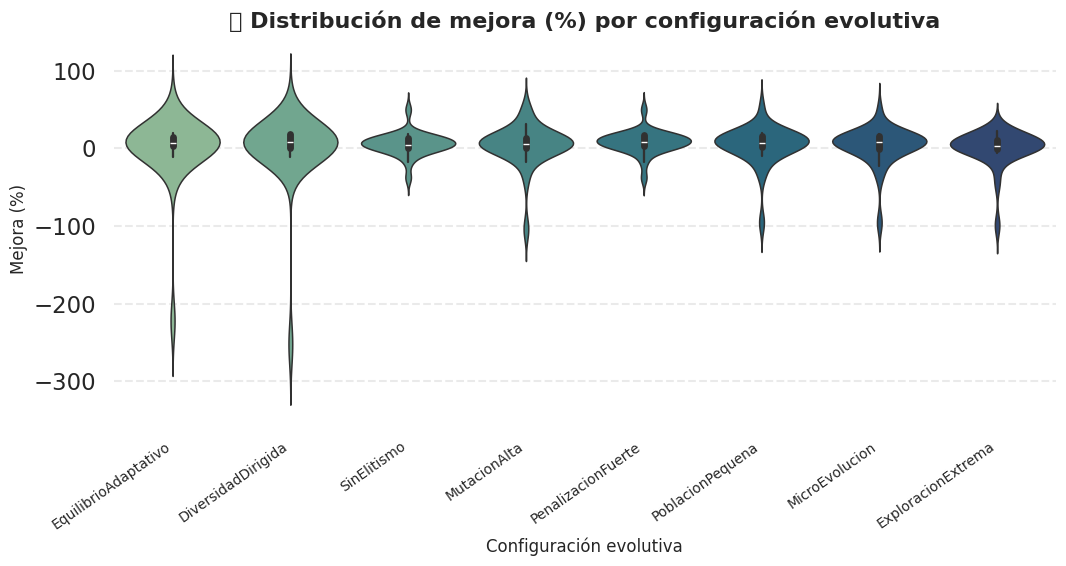

In [ ]:
# ---------------------------------------------------------------
# A. Distribución global de mejoras por configuración (violín)
# ---------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

df_hist_plot = df[df["config"] != "CruceAltoMutacionMedia"].copy()

sns.set_theme(style="whitegrid", context="talk", font="DejaVu Sans")

plt.figure(figsize=(11,6))
sns.violinplot(
    data=df_hist_plot,
    x="config",
    y="mejora_%",
    palette="crest",
    inner="box",       # muestra solo la caja interior (mediana y rango intercuartílico)
    linewidth=1.1,
    cut=3
)

plt.title("🎻 Distribución de mejora (%) por configuración evolutiva", fontsize=16, weight="bold")
plt.xlabel("Configuración evolutiva", fontsize=12)
plt.ylabel("Mejora (%)", fontsize=12)
plt.xticks(rotation=35, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


### Efectos de los parámetros principales

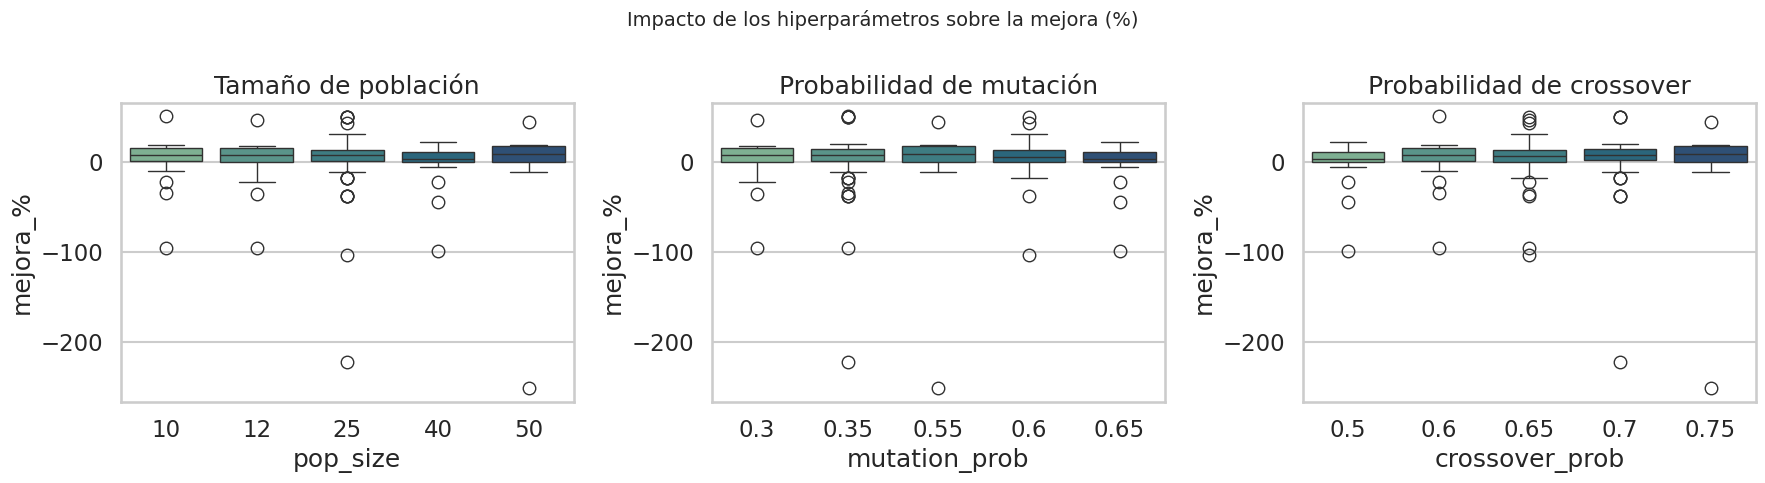

In [66]:
# ---------------------------------------------------------------
# B. Influencia de parámetros clave
# ---------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.boxplot(data=df_hist_plot, x="pop_size", y="mejora_%", ax=axes[0], palette="crest")
axes[0].set_title("Tamaño de población")
axes[0].set_xlabel("pop_size")

sns.boxplot(data=df_hist_plot, x="mutation_prob", y="mejora_%", ax=axes[1], palette="crest")
axes[1].set_title("Probabilidad de mutación")
axes[1].set_xlabel("mutation_prob")

sns.boxplot(data=df_hist_plot, x="crossover_prob", y="mejora_%", ax=axes[2], palette="crest")
axes[2].set_title("Probabilidad de crossover")
axes[2].set_xlabel("crossover_prob")

plt.suptitle("Impacto de los hiperparámetros sobre la mejora (%)", fontsize=14)
plt.tight_layout()
plt.show()


### Tiempo vs mejora

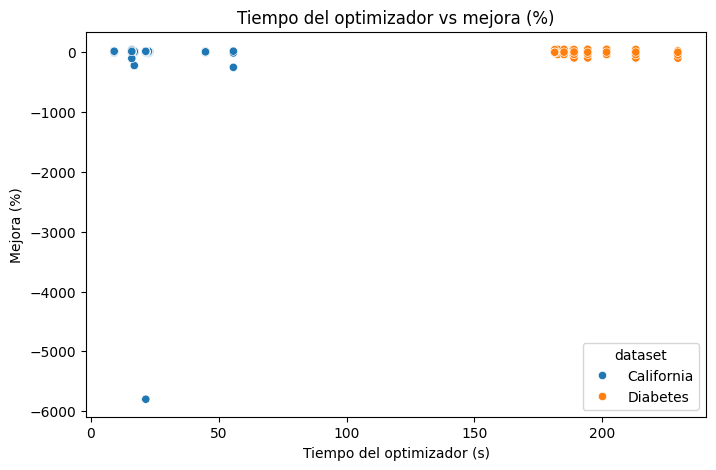

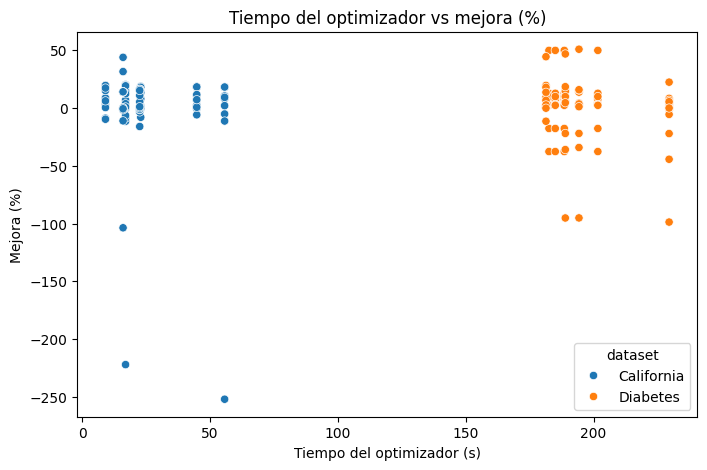

In [24]:
# ---------------------------------------------------------------
# D. Relación entre tiempo de ejecución y mejora obtenida
# ---------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="tiempo_optimizador_s", y="mejora_%", hue="dataset")
plt.title("Tiempo del optimizador vs mejora (%)")
plt.xlabel("Tiempo del optimizador (s)")
plt.ylabel("Mejora (%)")
plt.show()

# ---------------------------------------------------------------
# D. Relación entre tiempo de ejecución y mejora obtenida
# ---------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_hist_plot, x="tiempo_optimizador_s", y="mejora_%", hue="dataset")
plt.title("Tiempo del optimizador vs mejora (%)")
plt.xlabel("Tiempo del optimizador (s)")
plt.ylabel("Mejora (%)")
plt.show()


### Eficiencia temporal: mejora media por segundo

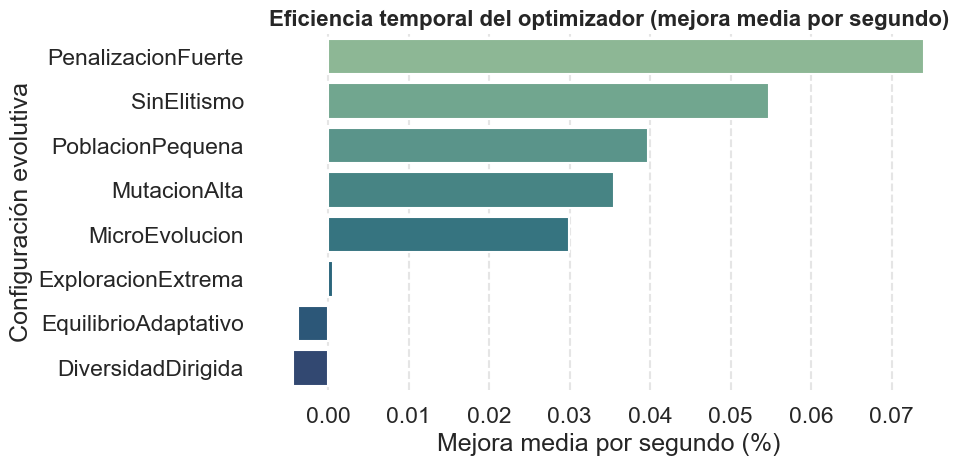

In [73]:
# ---------------------------------------------------------------
# Eficiencia temporal: mejora media por segundo
# ---------------------------------------------------------------
df_eff = (
    df_hist_plot.groupby("config", as_index=False)
      .agg({"mejora_%": "mean", "tiempo_optimizador_s": "mean"})
)
df_eff["eficiencia_%_por_s"] = df_eff["mejora_%"] / df_eff["tiempo_optimizador_s"]

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_eff.sort_values("eficiencia_%_por_s", ascending=False),
    x="eficiencia_%_por_s", y="config", palette="crest"
)
plt.title("Eficiencia temporal del optimizador (mejora media por segundo)", fontsize=16, weight="bold")
plt.xlabel("Mejora media por segundo (%)")
plt.ylabel("Configuración evolutiva")
plt.grid(axis="x", linestyle="--", alpha=0.5)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()



### Heatmap comparativo de configuraciones y modelos

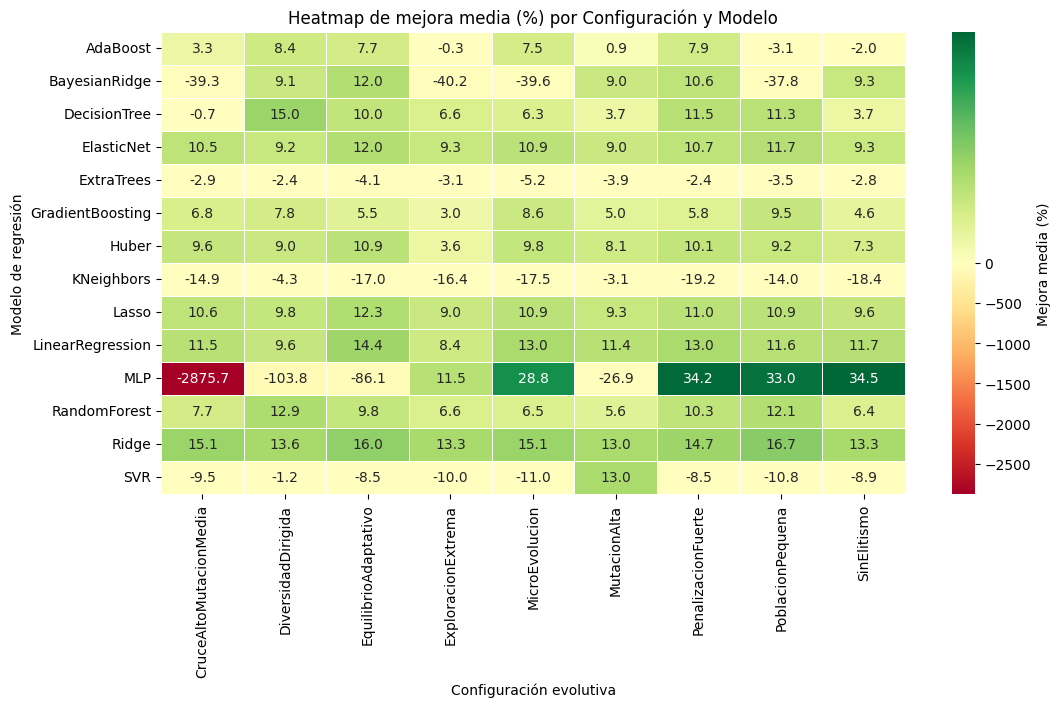

In [34]:
import matplotlib.colors as mcolors

# ---------------------------------------------------------------
# 🔥 Heatmap de mejora media (%) por Configuración y Modelo (divergente real)
# ---------------------------------------------------------------

pivot_cfg_model = df.pivot_table(values="mejora_%", index="modelo", columns="config", aggfunc="mean")

# Calcular límites para normalizar el color (centrado en 0)
vmin = np.nanmin(pivot_cfg_model.values)
vmax = np.nanmax(pivot_cfg_model.values)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

plt.figure(figsize=(12,6))
sns.heatmap(
    pivot_cfg_model,
    annot=True, fmt=".1f",
    cmap="RdYlGn",       # verde para positivo, rojo para negativo
    norm=norm,             # centro de la escala en 0
    linewidths=0.5,
    cbar_kws={"label": "Mejora media (%)"}
)
plt.title("Heatmap de mejora media (%) por Configuración y Modelo")
plt.xlabel("Configuración evolutiva")
plt.ylabel("Modelo de regresión")
plt.show()



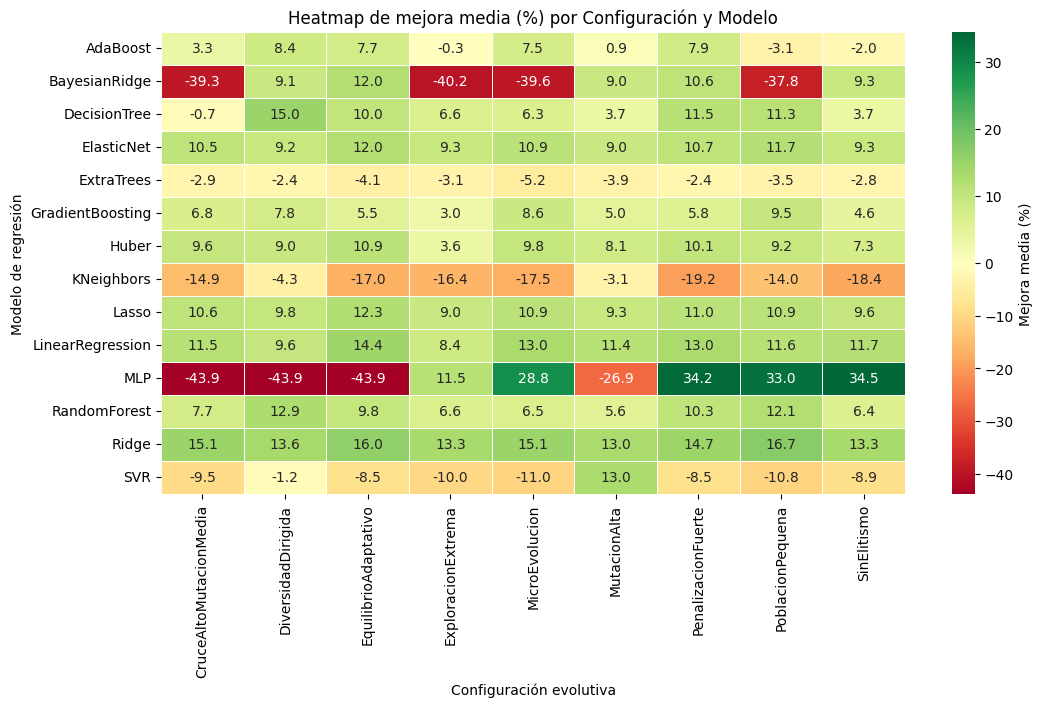

📊 Escala normalizada entre -43.9% y 34.5% (0 = blanco)


In [32]:
import matplotlib.colors as mcolors

# ================================================================
# 🎨 Heatmap mejorado: 0 = blanco | rojo = negativo | verde = positivo
# ================================================================

# Crear tabla pivote
pivot_cfg_model = df.pivot_table(values="mejora_%", index="modelo", columns="config", aggfunc="mean")

# --- 1️⃣ Eliminar outliers extremos (basado en IQR) ---
Q1 = pivot_cfg_model.stack().quantile(0.25)
Q3 = pivot_cfg_model.stack().quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

pivot_clamped = pivot_cfg_model.clip(lower=lower_bound, upper=upper_bound)

# --- 2️⃣ Calcular límites reales tras el filtrado ---
vmin = pivot_clamped.min().min()
vmax = pivot_clamped.max().max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# --- 3️⃣ Dibujar heatmap ---
plt.figure(figsize=(12,6))
sns.heatmap(
    pivot_clamped,
    annot=True, fmt=".1f",
    cmap="RdYlGn",      # Verde = positivo, rojo = negativo
    norm=norm,
    linewidths=0.5,
    cbar_kws={"label": "Mejora media (%)"}
)
plt.title("Heatmap de mejora media (%) por Configuración y Modelo")
plt.xlabel("Configuración evolutiva")
plt.ylabel("Modelo de regresión")
plt.show()

# Mostrar límites usados
print(f"📊 Escala normalizada entre {vmin:.1f}% y {vmax:.1f}% (0 = blanco)")


### Heatmap comparativo de configuraciones y datasets

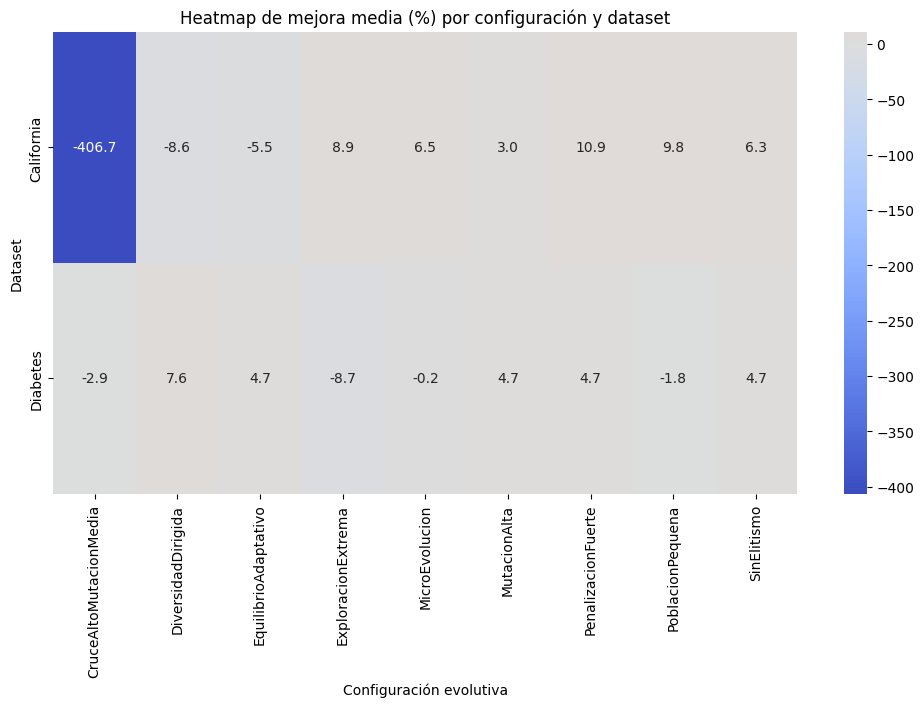

In [35]:
# ---------------------------------------------------------------
# F. Heatmap de mejora media por configuración y dataset
# ---------------------------------------------------------------
pivot_cfg_dataset = df.pivot_table(values="mejora_%", index="dataset", columns="config", aggfunc="mean")

plt.figure(figsize=(12,6))
sns.heatmap(pivot_cfg_dataset, annot=True, fmt=".1f", cmap="coolwarm", center=0)
plt.title("Heatmap de mejora media (%) por configuración y dataset")
plt.xlabel("Configuración evolutiva")
plt.ylabel("Dataset")
plt.show()


### Ranking global de modelos

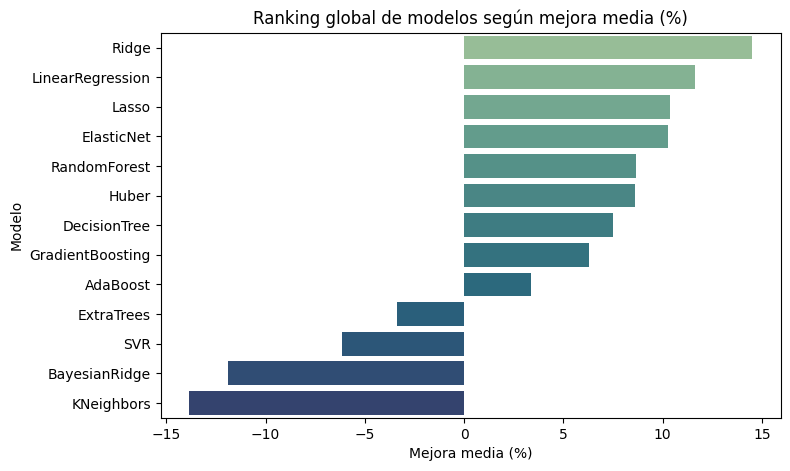

📈 Mejora media por modelo:


modelo
Ridge               14.53
LinearRegression    11.62
Lasso               10.37
ElasticNet          10.29
RandomForest         8.66
Huber                8.62
DecisionTree         7.48
GradientBoosting     6.30
AdaBoost             3.37
ExtraTrees          -3.39
SVR                 -6.13
BayesianRidge      -11.89
KNeighbors         -13.87
Name: mejora_%, dtype: float64

In [37]:
# ---------------------------------------------------------------
# G. Ranking global de modelos según mejora promedio
# ---------------------------------------------------------------
ranking_modelos = df[df["modelo"] != "MLP"].groupby("modelo")["mejora_%"].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=ranking_modelos.values, y=ranking_modelos.index, palette="crest")
plt.title("Ranking global de modelos según mejora media (%)")
plt.xlabel("Mejora media (%)")
plt.ylabel("Modelo")
plt.show()

print("📈 Mejora media por modelo:")
display(ranking_modelos.round(2))


### Correlaciones entre variables

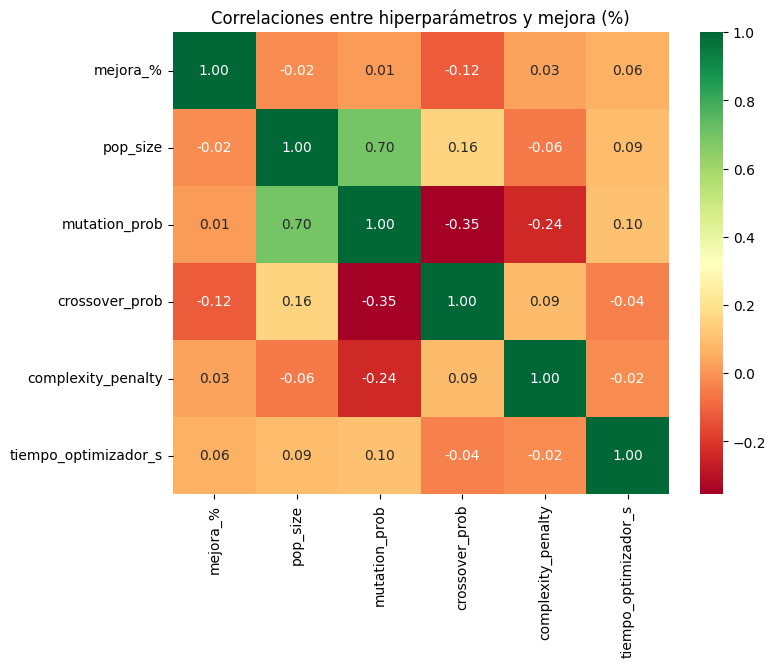

In [38]:
# ---------------------------------------------------------------
# H. Matriz de correlación entre parámetros y mejora
# ---------------------------------------------------------------
corr = df[["mejora_%", "pop_size", "mutation_prob", "crossover_prob", "complexity_penalty", "tiempo_optimizador_s"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="RdYlGn", fmt=".2f")
plt.title("Correlaciones entre hiperparámetros y mejora (%)")
plt.show()


## Validación en nuevos datasets


🏁 Dataset: California
[STOP] Early stopping at gen 50
[DONE] Best fitness: -0.40154 | Time: 25.1s
📉 MSE original: 0.5411
🚀 MSE optimizado: 0.4512
✅ Mejora relativa: 16.62%
🧬 Best fitness: -0.40154

🏁 Dataset: Diabetes
[DONE] Best fitness: -3373.03930 | Time: 105.4s
📉 MSE original: 2848.3107
🚀 MSE optimizado: 2665.4104
✅ Mejora relativa: 6.42%
🧬 Best fitness: -3373.03930

🏁 Dataset: ConcreteStrength
[DONE] Best fitness: -39.30158 | Time: 149.4s
📉 MSE original: 101.5969
🚀 MSE optimizado: 47.7905
✅ Mejora relativa: 52.96%
🧬 Best fitness: -39.30158

🏁 Dataset: EnergyEfficiency
[DONE] Best fitness: -4.07039 | Time: 95.8s
📉 MSE original: 8.9605
🚀 MSE optimizado: 4.5297
✅ Mejora relativa: 49.45%
🧬 Best fitness: -4.07039

🏁 Dataset: WineQualityRed
[DONE] Best fitness: -0.42310 | Time: 123.9s
📉 MSE original: 0.3883
🚀 MSE optimizado: 0.3841
✅ Mejora relativa: 1.09%
🧬 Best fitness: -0.42310

🏁 Dataset: AirfoilNoise
[DONE] Best fitness: -13.57968 | Time: 133.8s
📉 MSE original: 22.9996
🚀 MSE optim

,Dataset,Samples,Features,MSE_original,MSE_optimizado,Mejora_%,Best_fit
2,ConcreteStrength,1030,8,101.5969,47.7905,52.96,-39.30158
3,EnergyEfficiency,768,8,8.9605,4.5297,49.45,-4.07039
0,California,20640,8,0.5411,0.4512,16.62,-0.40154
5,AirfoilNoise,1503,5,22.9996,19.2326,16.38,-13.57968
1,Diabetes,442,10,2848.3107,2665.4104,6.42,-3373.03930
4,WineQualityRed,1599,11,0.3883,0.3841,1.09,-0.42310


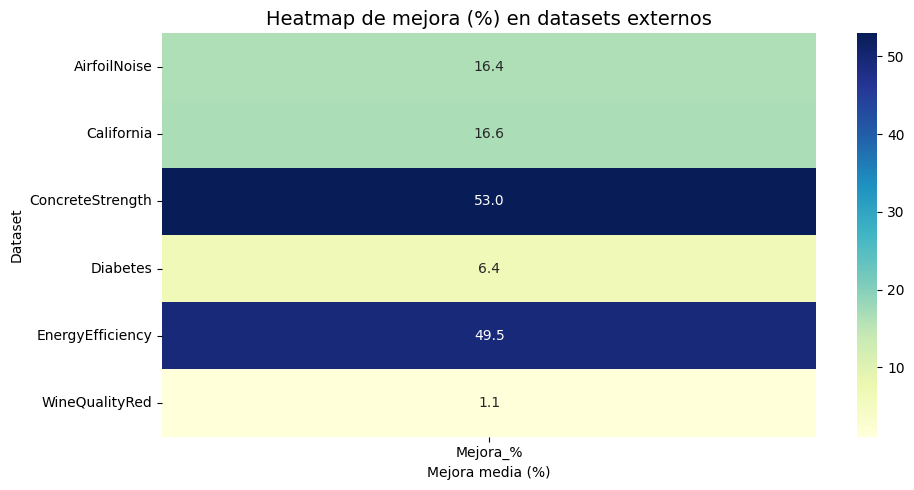

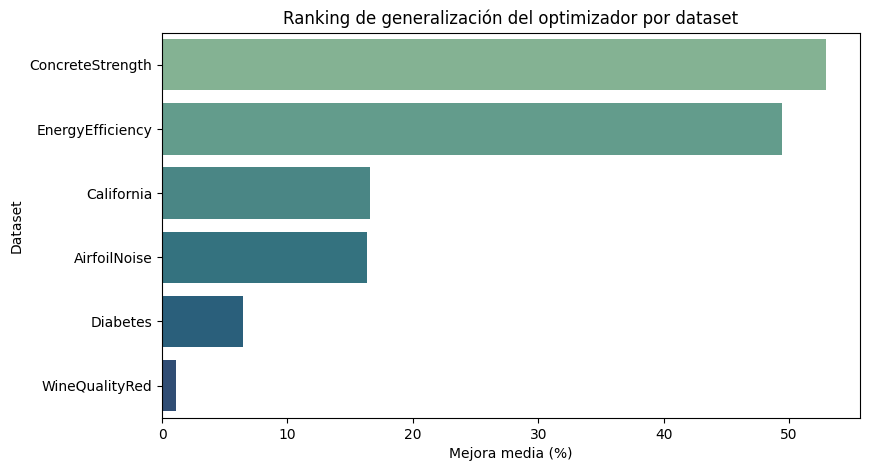

In [ ]:
# ================================================================
# 9️⃣ VALIDACIÓN EN NUEVOS DATASETS (GENERALIZACIÓN)
# ================================================================
# En esta fase se evalúa la capacidad del EvolutionaryOptimizer
# para generalizar su rendimiento a datasets no utilizados en
# la configuración inicial del experimento.
# ================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from evopt import EvolutionaryOptimizer

# ================================================================
# 📚 Carga de datasets (locales + UCI)
# ================================================================
DATASETS = {}

# 🔹 Datasets locales
DATASETS["California"] = pd.read_csv("data/california.csv")
DATASETS["Diabetes"] = pd.read_csv("data/diabetes.csv")

# 🔹 Datasets UCI
try:
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    df = pd.read_excel(url)
    df.columns = ["cement", "slag", "flyash", "water", "superplasticizer", "coarseagg", "fineagg", "age", "strength"]
    DATASETS["ConcreteStrength"] = df
except Exception as e:
    print("⚠️ Concrete no cargado:", e)

try:
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
    df = pd.read_excel(url)
    df.columns = ["X1","X2","X3","X4","X5","X6","X7","X8","Y1","Y2"]
    df = df.drop(columns=["Y2"])
    DATASETS["EnergyEfficiency"] = df
except Exception as e:
    print("⚠️ Energy no cargado:", e)

try:
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    df = pd.read_csv(url, sep=";")
    DATASETS["WineQualityRed"] = df
except Exception as e:
    print("⚠️ Wine no cargado:", e)

try:
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat"
    df = pd.read_csv(url, sep="\t", header=None)
    df.columns = ["frequency", "angle", "chord_length", "velocity", "thickness", "sound_pressure"]
    DATASETS["AirfoilNoise"] = df
except Exception as e:
    print("⚠️ Airfoil no cargado:", e)


# ================================================================
# ⚙️ Configuración óptima (según análisis previo)
# ================================================================
best_config = {
    "maxtime": 90,
    "pop_size": 30,
    "crossover_prob": 0.7,
    "mutation_prob": 0.3,
    "elitism": True,
    "patience": 40,
    "random_state": 42,
    "min_genes": 3,
    "max_genes": 10,
    "complexity_penalty": 0.001
}

# ================================================================
# 🚀 Entrenamiento y evaluación
# ================================================================
results = []

for name, df in DATASETS.items():
    print("\n" + "="*100)
    print(f"🏁 Dataset: {name}")
    print("="*100)

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    evo = EvolutionaryOptimizer(**best_config)
    evo.fit(X_train, y_train)

    # ------------------------------------------------------------
    # 📊 Evaluación antes y después de la evolución
    # ------------------------------------------------------------
    model = LinearRegression()

    # 🔸 Baseline (sin transformación)
    model.fit(X_train, y_train)
    preds_orig = model.predict(X_test)
    mse_orig = mean_squared_error(y_test, preds_orig)

    # 🔸 Con features evolucionadas
    X_train_opt = evo.transform(X_train)
    X_test_opt = evo.transform(X_test)
    model.fit(X_train_opt, y_train)
    preds_opt = model.predict(X_test_opt)
    mse_opt = mean_squared_error(y_test, preds_opt)

    # 🔸 Mejora relativa
    mejora = 1 - mse_opt / mse_orig

    print(f"📉 MSE original: {mse_orig:.4f}")
    print(f"🚀 MSE optimizado: {mse_opt:.4f}")
    print(f"✅ Mejora relativa: {mejora:.2%}")
    print(f"🧬 Best fitness: {evo.best_fit:.5f}")

    results.append({
        "Dataset": name,
        "Samples": X.shape[0],
        "Features": X.shape[1],
        "MSE_original": round(mse_orig, 4),
        "MSE_optimizado": round(mse_opt, 4),
        "Mejora_%": round(mejora * 100, 2),
        "Best_fit": round(evo.best_fit, 5)
    })

### Ranking de mejora por dataset

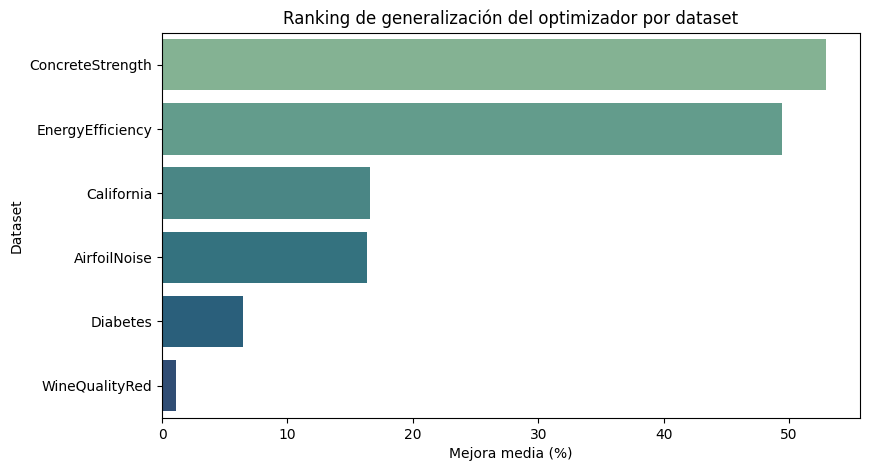

In [42]:
plt.figure(figsize=(9,5))
sns.barplot(data=df_res.sort_values("Mejora_%", ascending=False),
            x="Mejora_%", y="Dataset", palette="crest")
plt.title("Ranking de generalización del optimizador por dataset")
plt.xlabel("Mejora media (%)")
plt.ylabel("Dataset")
plt.show()


## Evaluación multimodelo

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

MODELOS = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

# Reutilizar los datasets y la mejor configuración del bloque anterior
multi_results = []

for name, df in DATASETS.items():
    print("\n" + "="*100)
    print(f"🏁 Dataset: {name}")
    print("="*100)

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    evo = EvolutionaryOptimizer(**best_config)
    evo.fit(X_train, y_train)
    X_train_opt = evo.transform(X_train)
    X_test_opt = evo.transform(X_test)

    for model_name, model in MODELOS.items():
        print(f"\n🔹 Modelo: {model_name}")
        model.fit(X_train, y_train)
        mse_orig = mean_squared_error(y_test, model.predict(X_test))

        model.fit(X_train_opt, y_train)
        mse_opt = mean_squared_error(y_test, model.predict(X_test_opt))

        mejora = 1 - mse_opt / mse_orig
        print(f"   📉 MSE original: {mse_orig:.4f}")
        print(f"   🚀 MSE optimizado: {mse_opt:.4f}")
        print(f"   ✅ Mejora relativa: {mejora:.2%}")

        multi_results.append({
            "Dataset": name,
            "Modelo": model_name,
            "MSE_original": round(mse_orig, 4),
            "MSE_optimizado": round(mse_opt, 4),
            "Mejora_%": round(mejora * 100, 2),
            "Best_fit": round(evo.best_fit, 5)
        })

# Convertir resultados a DataFrame
df_multi = pd.DataFrame(multi_results)

# ================================================================
# 📊 Resultados globales
# ================================================================
print("\n" + "="*80)
print("📊 RESULTADOS MULTIMODELO FINALES")
print("="*80)
display(df_multi.sort_values(["Dataset", "Modelo"]))


🏁 Dataset: California
[STOP] Early stopping at gen 50
[DONE] Best fitness: -0.40154 | Time: 28.0s

🔹 Modelo: LinearRegression
   📉 MSE original: 0.5411
   🚀 MSE optimizado: 0.4512
   ✅ Mejora relativa: 16.62%

🔹 Modelo: RandomForest
   📉 MSE original: 0.2542
   🚀 MSE optimizado: 0.2586
   ✅ Mejora relativa: -1.71%

🔹 Modelo: KNN
   📉 MSE original: 1.1322
   🚀 MSE optimizado: 1.0579
   ✅ Mejora relativa: 6.56%

🏁 Dataset: Diabetes
[DONE] Best fitness: -3373.03930 | Time: 126.1s

🔹 Modelo: LinearRegression
   📉 MSE original: 2848.3107
   🚀 MSE optimizado: 2665.4104
   ✅ Mejora relativa: 6.42%

🔹 Modelo: RandomForest
   📉 MSE original: 3010.1126
   🚀 MSE optimizado: 2514.7589
   ✅ Mejora relativa: 16.46%

🔹 Modelo: KNN
   📉 MSE original: 3060.1665
   🚀 MSE optimizado: 4273.9647
   ✅ Mejora relativa: -39.66%

🏁 Dataset: ConcreteStrength
[DONE] Best fitness: -39.30158 | Time: 169.1s

🔹 Modelo: LinearRegression
   📉 MSE original: 101.5969
   🚀 MSE optimizado: 47.7905
   ✅ Mejora relativa: 5

,Dataset,Modelo,MSE_original,MSE_optimizado,Mejora_%,Best_fit
17,AirfoilNoise,KNN,38.8219,24.9666,35.69,-13.57968
15,AirfoilNoise,LinearRegression,22.9996,19.2326,16.38,-13.57968
16,AirfoilNoise,RandomForest,3.1996,3.1818,0.56,-13.57968
2,California,KNN,1.1322,1.0579,6.56,-0.40154
0,California,LinearRegression,0.5411,0.4512,16.62,-0.40154
1,California,RandomForest,0.2542,0.2586,-1.71,-0.40154
8,ConcreteStrength,KNN,80.6963,69.0961,14.38,-39.30158
6,ConcreteStrength,LinearRegression,101.5969,47.7905,52.96,-39.30158
7,ConcreteStrength,RandomForest,30.5214,27.6880,9.28,-39.30158
5,Diabetes,KNN,3060.1665,4273.9647,-39.66,-3373.03930


### Heatmap de mejora (%) por modelo y dataset

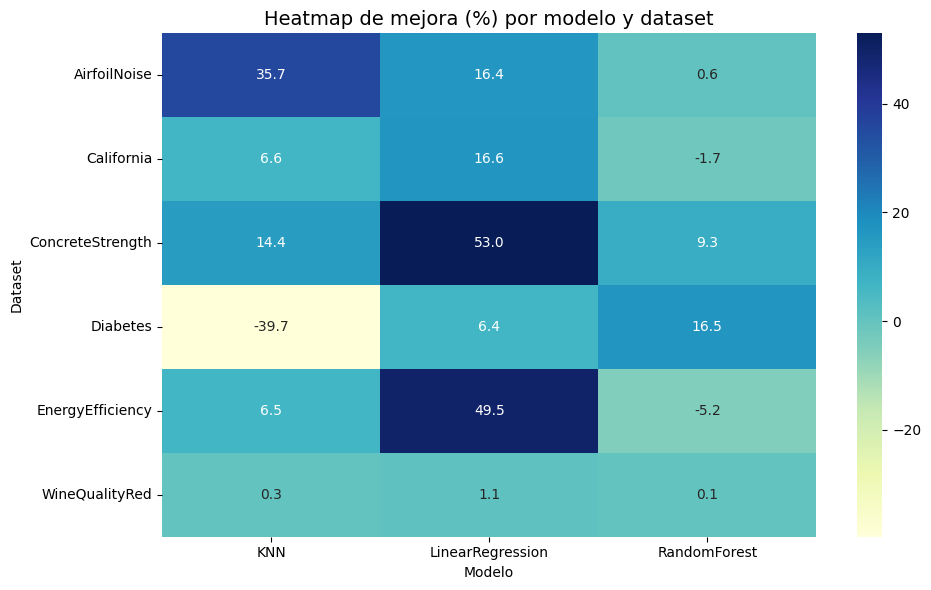

In [46]:
plt.figure(figsize=(10,6))
sns.heatmap(df_multi.pivot_table(values="Mejora_%", index="Dataset", columns="Modelo", aggfunc="mean"),
            annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Heatmap de mejora (%) por modelo y dataset", fontsize=14)
plt.ylabel("Dataset")
plt.xlabel("Modelo")
plt.tight_layout()
plt.show()

### Mejora media de cada modelo por dataset

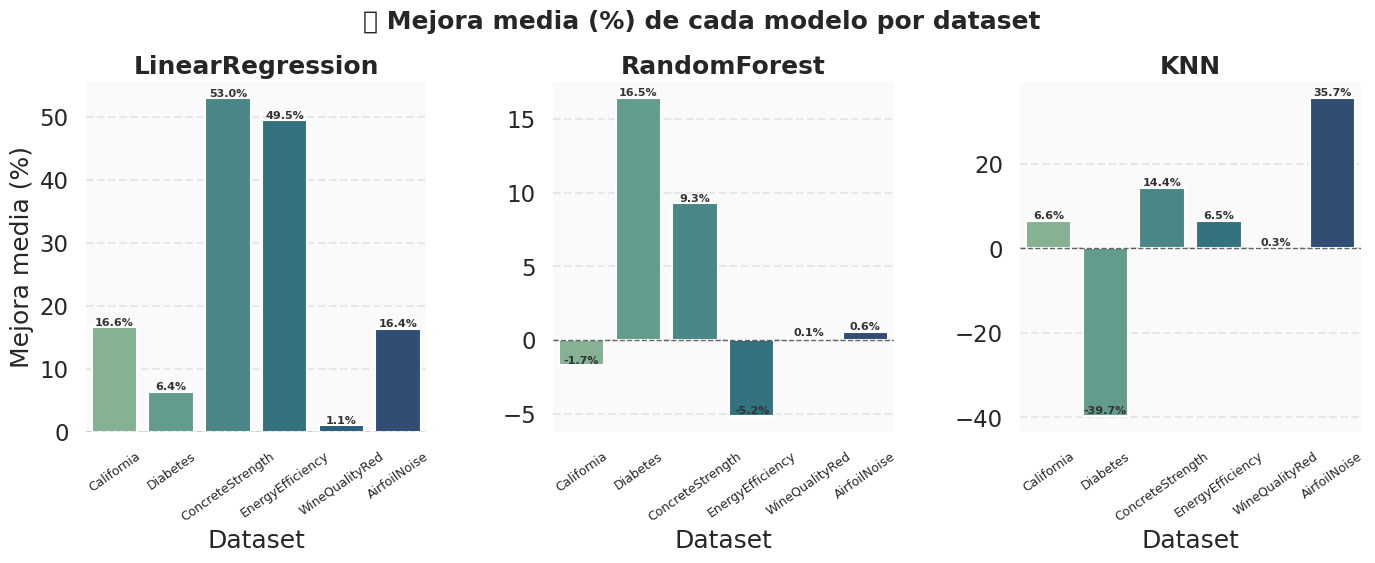

In [ ]:
# ================================================================
# 🎨 Versión ajustada: sin solapamientos en los nombres de datasets
# ================================================================
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font="DejaVu Sans", context="talk")

# Crear FacetGrid con más altura y espacio entre subplots
g = sns.FacetGrid(
    df_multi,
    col="Modelo",
    col_wrap=3,
    height=4.8,
    sharey=False,
    despine=False
)


g.map_dataframe(
    sns.barplot,
    x="Dataset",
    y="Mejora_%",
    estimator="mean",
    errorbar="sd",
    palette="crest",
    edgecolor="white"
)

# Personalización del formato
g.set_titles(col_template="{col_name}", fontweight="bold", fontsize=16)
g.set_axis_labels("Dataset", "Mejora media (%)")

for ax in g.axes.flatten():
    ax.tick_params(axis="x", labelrotation=35, labelsize=9)  # 🔹 más pequeño y más girado
    ax.axhline(0, color="black", lw=1, ls="--", alpha=0.6)
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.set_facecolor("#fafafa")

    # Añadir etiquetas sobre las barras
    for p in ax.patches:
        value = p.get_height()
        if not np.isnan(value):
            ax.annotate(f"{value:.1f}%",
                        (p.get_x() + p.get_width() / 2., value),
                        ha='center', va='bottom',
                        fontsize=8, color="#333", weight="semibold")

# 🔹 Ajustes globales del layout (más espacio arriba)
plt.subplots_adjust(top=0.88, hspace=0.45, bottom=0.15)
g.fig.suptitle("Mejora media (%) de cada modelo por dataset", fontsize=18, weight="bold", y=1.03)
sns.despine(left=True, bottom=True)
plt.show()
